In [172]:
%cd ..































































































































































































































































































































































































































































































































































































































































































/home/prayson/Code/hadithi


In [173]:







import pandas as pd
import numpy as np

pd.options.plotting.backend = "plotly"

In [174]:
df = pd.read_csv("assets/bolig.csv.gzip", compression="gzip", parse_dates=["soldDate"])
df.sample(4)

FileNotFoundError: [Errno 2] No such file or directory: 'assets/bolig.csv.gzip'

In [ ]:
df.columns

In [ ]:
# Sorting fam_salg away
SALES_TYPE = "Alm. Salg"
# Sorting apartments away that where sold for under 500.000 and above 9.000.000
LOWER_PRICE, HIGHER_PRICE = 450_000, 9_500_000

# Sorting apartments away that have above 5 roomes doe to the likelyhood of it being under 0.001%procent
NUMBER_OF_ROOMS = 5

# Number of Days from Max Date
DAYS_FROM_MAX_DATE = 31 + 30 + 31 + 30


alm_salg_df = (
    df.loc[
        (df["saleType"].eq(SALES_TYPE))
        & (df["price"].between(LOWER_PRICE, HIGHER_PRICE))
        & (df["rooms"].le(NUMBER_OF_ROOMS))
    ]
    .assign(
        floor=lambda d: d["address"]
        .str.extract(r",\s*(?P<floor>\d+|st)(?=\s*[a-z]*\.?\s|$)")
        .replace("st", 0)
        .fillna(0)
        .astype(int)
    )
#.assign(rooms = lambda d: np.where(d["rooms"].eq(6), 0, d["rooms"])) # changes room 6 to 0 which is dropped
    .assign(
        days_from_latest=lambda d: (d["soldDate"].max() - d["soldDate"]).dt.days
    )
    .sort_values(by="soldDate")
    .loc[lambda d: d["days_from_latest"] <= DAYS_FROM_MAX_DATE ]
)

(alm_salg_df
  .sample(5)
  .loc[:, ["price", "rooms", "size", "soldDate"]]
  .assign(soldAge = lambda d: (d["soldDate"].dt.date - pd.to_datetime("1991-01-01")).dt.days/365)
  .loc[:,["price", "rooms", "size", "soldAge"]] 
)

In [ ]:
alm_salg_df.columns

In [ ]:
from pathlib import Path
import plotly.express as px

px.set_mapbox_access_token(Path(".mapbox_token").read_text())

In [ ]:
px.scatter_mapbox(
    alm_salg_df,
    lat="latitude",
    lon="longitude",
    color="size",
    size="price",
    color_continuous_scale=px.colors.cyclical.IceFire,
    size_max=5,
    zoom=11,
    title="Normal Sales Apartments in Copenhagen",
    hover_name="address",
    hover_data=["rooms", "buildYear", "floor"],
    center=dict(
        lat=55.6861,
        lon=12.5388,
    ),
    width=1200,
    height=800,
)

In [ ]:
features = [
    "address",
    "zipCode",
    "soldDate",
    "rooms",
    "floor",
    "size",
    "buildYear",
    "latitude",
    "longitude",
    "municipalityCode",
    "estateCode",
    "city",
    "price",
]



In [ ]:
explore_data = alm_salg_df[features].astype(
    {
        "rooms": np.int8,
        "size": np.int16,
        "buildYear": np.int32,
        "municipalityCode": np.int32,
        "estateCode": np.int32,
        "zipCode": np.int32,
    }
)
explore_data = (
    explore_data.assign(
        soldYear=lambda d: d["soldDate"].dt.year,
        soldMonth=lambda d: d["soldDate"].dt.month,
    ).drop(columns=["address", "soldDate"])

)

In [ ]:
order_columns = [
    "price",
    "size",
    "rooms",
    "floor",
    "longitude",
    "latitude",
    "buildYear",
    "soldMonth",
    "soldYear",
    "zipCode",
    "city",
]

## Middle Age Tools

In [ ]:
import hiplot as hip

In [ ]:
explore_data.columns[::-1]

In [ ]:
viz = hip.Experiment.from_dataframe(explore_data[order_columns])

In [ ]:
viz.display();  # soldMonth has no effect & interestubg suze of 857, I think the correct is 85.7

In [ ]:
explore_data = (
    explore_data
    #.drop(columns=["address", "soldDate"])
    # after the viz, we discovered Build Year 0 and size 857?
    .loc[lambda d: (d['buildYear'].ne(0))]
)

In [ ]:
alm_salg_df_filtered = pd.merge(
    alm_salg_df[["address", "soldDate"]],
    explore_data,
    how="inner",
    left_index=True,
    right_index=True,
)

In [ ]:
# alm_salg_df_filtered.loc[lambda d: d["floor"].gt(24)]

In [ ]:
alm_salg_df_filtered.shape

In [ ]:
interesting_columns = [
    "price",
    "size",
    "rooms",
    "floor",
    "longitude",
    "latitude",
    "buildYear",
    "soldYear",
    "zipCode",
    "city",
]

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = explore_data[
    [
        "size",
        "rooms",
        "longitude",
        "latitude",
        "buildYear",
        "floor",
        "soldYear",
        "zipCode",
        "city",
    ]
]
y = explore_data["price"]

In [175]:
train_data = X.assign(price=y)

In [176]:
train_data.columns

Index(['size', 'rooms', 'longitude', 'latitude', 'buildYear', 'floor',
       'soldYear', 'zipCode', 'city', 'price'],
      dtype='object')

In [177]:
train_data["rooms"].value_counts(normalize=False)

rooms
2    593
3    406
4    162
1     95
5     61
Name: count, dtype: int64

In [178]:
from sklearn.linear_model import LinearRegression
import patsy as ps

In [179]:
train_data.sample(2)

size  rooms  longitude   latitude  buildYear  floor  soldYear  zipCode  \
18297    38      1  12.537557  55.665115       1902      2      2023     1799   
18542    58      2  12.510014  55.668022       1932      0      2023     2500   

              city    price  
18297  København V  2000000  
18542        Valby  2000000

In [180]:
# price ~ size

formula = (
    "price ~ size + C(rooms) + C(buildYear) + latitude + longitude - 1"
)

In [181]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter(action="ignore", category=FutureWarning)

    y_, X_ = ps.dmatrices(formula, data=train_data)

In [182]:
X_train, X_test, y_train, y_test = train_test_split(
    X_, y_, train_size=0.9, random_state=42
)
y_train, y_test = y_train.ravel(), y_test.ravel()

In [183]:
LinearRegression(n_jobs=-1).fit(X_train, y_train).score(X_test, y_test)

-1.5496027243971507e+20

In [184]:
from sklearn.neighbors import KNeighborsRegressor

In [185]:
KNeighborsRegressor(n_jobs=-1, n_neighbors=7).fit(X_train, y_train).score(
    X_test, y_test
)

0.6821181276657124

In [186]:
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor

In [187]:
øGradientBoostingRegressor(
    learning_rate=0.7,
    n_estimators=107,
    random_state=42,
).fit(
    X_train, y_train
).score(X_test, y_test)

0.863074589559821

In [188]:
ExtraTreesRegressor(n_jobs=-1, 
                    n_estimators=107,
                    random_state=42,
                   ).fit(X_train, y_train).score(
    X_test, y_test
)

0.8529191344585347

In [37]:
from flaml import AutoML

In [43]:
automl = AutoML()

automl_settings = {
    "time_budget": 60 * 7,  # in seconds
    "metric": "rmse",
    "task": "regression",
    "log_file_name": "bolig.log",
    "estimator_list": [
        "xgboost",
        "lgbm",
        "catboost",
        "extra_tree",
    ],
    "sample": True,
    "n_jobs": -1,
}

automl.fit(X_train=X_train, y_train=y_train, **automl_settings)

[flaml.automl.logger: 01-08 10:29:19] {1679} INFO - task = regression
[flaml.automl.logger: 01-08 10:29:19] {1690} INFO - Evaluation method: cv
[flaml.automl.logger: 01-08 10:29:19] {1788} INFO - Minimizing error metric: rmse
[flaml.automl.logger: 01-08 10:29:19] {1900} INFO - List of ML learners in AutoML Run: ['xgboost', 'lgbm', 'catboost', 'extra_tree']
[flaml.automl.logger: 01-08 10:29:19] {2218} INFO - iteration 0, current learner xgboost
[flaml.automl.logger: 01-08 10:29:19] {2344} INFO - Estimated sufficient time budget=736s. Estimated necessary time budget=1s.
[flaml.automl.logger: 01-08 10:29:19] {2391} INFO -  at 0.1s,	estimator xgboost's best error=2958538.0271,	best estimator xgboost's best error=2958538.0271
[flaml.automl.logger: 01-08 10:29:19] {2218} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 01-08 10:29:19] {2391} INFO -  at 0.2s,	estimator lgbm's best error=1503893.5797,	best estimator lgbm's best error=1503893.5797
[flaml.automl.logger: 01-08 10:29

In [44]:
automl.score(X_test, y_test)

0.8841095611272191

In [45]:
automl.best_estimator, automl.best_config_per_estimator.get(automl.best_estimator)

('xgboost',
 {'n_estimators': 759,
  'max_leaves': 17,
  'min_child_weight': 1.0985898529515317,
  'learning_rate': 0.03245066619296891,
  'subsample': 0.6980701498823624,
  'colsample_bylevel': 0.7937544467235449,
  'colsample_bytree': 0.9097763346680299,
  'reg_alpha': 0.02540958839565814,
  'reg_lambda': 0.004781355627452111})

## End yet another

In [46]:

from sklearn.metrics import mean_squared_error, r2_score

In [47]:
%%time
y_pred = automl.predict(X_test).round(0).astype(int)
int(mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False))

CPU times: user 86 ms, sys: 3.91 ms, total: 89.9 ms
Wall time: 14 ms


529641

In [42]:
# automlx is slow in scoring

In [48]:
import pickle

In [49]:
Path("notebooks/models/automlII.pkl").write_bytes(
    pickle.dumps(automl, pickle.HIGHEST_PROTOCOL)
)

1584354

In [50]:
predictor = pickle.loads(Path("notebooks/models/automlII.pkl").read_bytes()).model

In [51]:
predicted_price = predictor.predict(X_test).round(0).astype(int)

In [52]:
def restore_category(df, name):
    return (
        df[df.columns[df.columns.str.startswith(f"C({name})")]]
        .idxmax(axis=1)
        .str.extract(f"\[\.|(?P<{name}>\d+)\]")
        .astype(int)
    )

In [53]:
p = (
    pd.DataFrame(X_test, columns=X_.design_info.column_names)
    .assign(
        rooms=lambda d: restore_category(d, name="rooms"),
        buildYear=lambda d: restore_category(d, name="buildYear"),
        #soldYear=lambda d: restore_category(d, name="soldYear"),
        actual_price=y_test,
        predicted_price=predicted_price,
        residual=lambda d: d["predicted_price"] - d["actual_price"],
        under_estimate=lambda d: d["residual"] < 0,
    )
    # .sort_values(by=["actual_price", "predicted_price"]
    .loc[:, lambda d: d.columns[~d.columns.str.startswith("C(")]]
    .reset_index(drop=True)
)

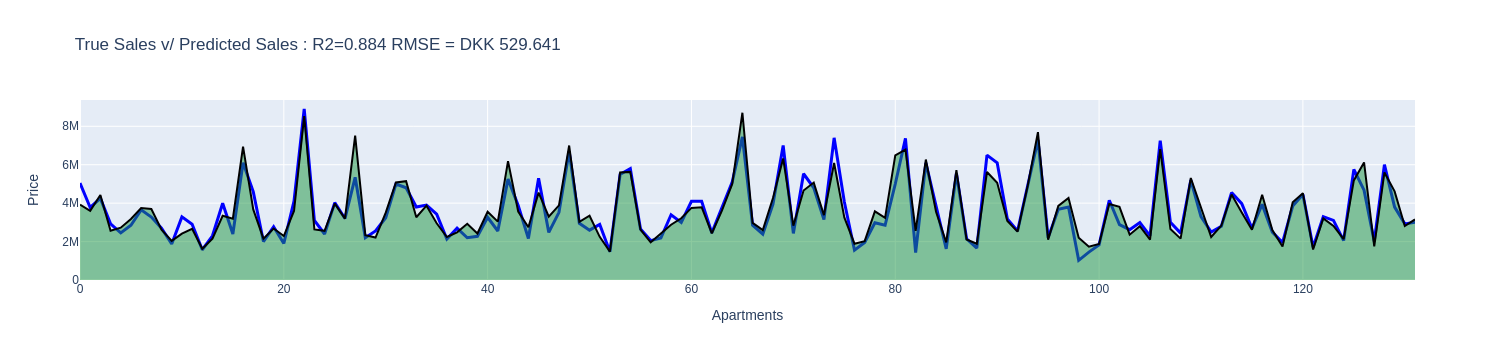

In [54]:
fig_size = {"width": 1200, "height": 400}
R2 = predictor.score(X_test, y_test).round(3)
RMSE = f"{int(mean_squared_error(y_true=y_test, y_pred=predicted_price, squared=False)):,}".replace(
    ",", "."
)


(
    p.plot(
        kind="line",
        y="actual_price",
        title=f"True Sales v/ Predicted Sales : {R2=} RMSE = DKK {RMSE}",
    )
    .update_traces(line=dict(color="blue", width=3))
    .update_layout(
        hovermode="x unified",
        xaxis_title="Apartments",
        yaxis_title="Price",
    )
    .add_traces(
        p.plot(kind="area", y="predicted_price")
        .update_traces(
            line=dict(color="black", width=2),
            fill="tonexty",
            fillcolor='rgba(26,150,65,0.5)',
        )
        .data
    )
)

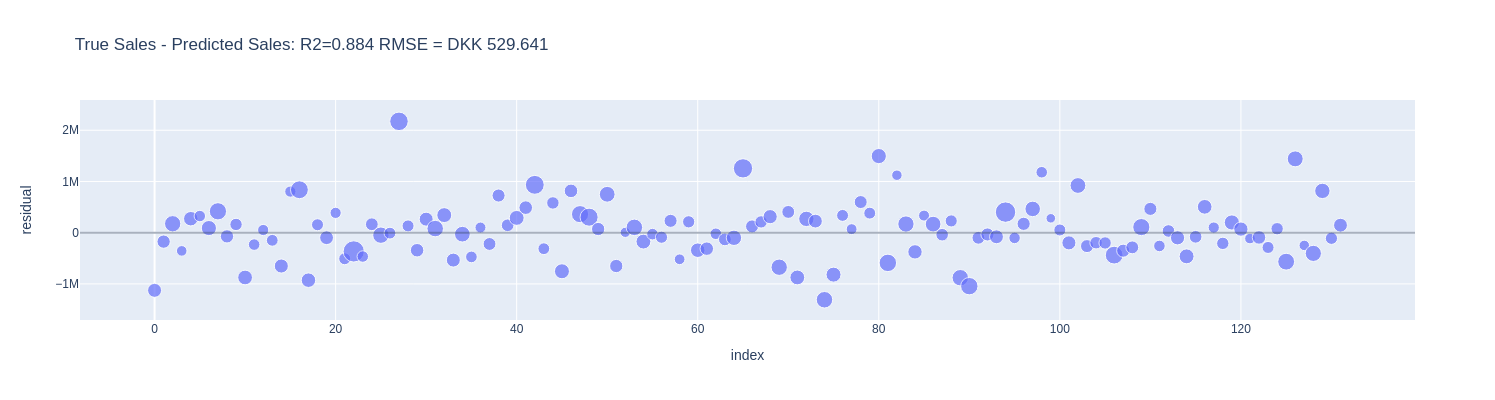

In [56]:
(
    p.plot(
        kind="scatter",
        y="residual",
        x=p.index,
        size="size",
        size_max=15,
        title=f"True Sales - Predicted Sales: {R2=} RMSE = DKK {RMSE}",
        **fig_size,
    )
    .add_hline(
        y=0,
        opacity=0.4,
    )
    .update_traces(mode="markers")
    .update_layout(hovermode="y")
)

In [57]:
# worst 5
p.assign(residual=lambda d: abs(d["residual"])).sort_values("residual").reset_index(
    drop=True
).iloc[-5:]

size   latitude  longitude  rooms  buildYear  actual_price  \
127  139.0  55.659700  12.633283      4       1962     7450000.0   
128  102.0  55.672170  12.532495      4       1908     7400000.0   
129   95.0  55.666460  12.594339      3       2018     4675000.0   
130   86.0  55.699894  12.584923      3       1960     4995000.0   
131  128.0  55.665016  12.579160      4       1970     5345000.0   

     predicted_price   residual  under_estimate  
127          8706451  1256451.0           False  
128          6090894  1309106.0            True  
129          6116728  1441728.0           False  
130          6490840  1495840.0           False  
131          7519025  2174025.0           False

In [58]:
# best 5
p.assign(residual=lambda d: abs(d["residual"])).sort_values("residual").reset_index(
    drop=True
).iloc[:5]

size   latitude  longitude  rooms  buildYear  actual_price  \
0  39.0  55.692753  12.499410      1       1937     1470000.0   
1  52.0  55.686844  12.567264      2       1880     3200000.0   
2  50.0  55.691673  12.568008      1       1963     2450000.0   
3  50.0  55.707120  12.588407      1       1935     2650000.0   
4  92.0  55.684822  12.490923      3       1981     3900000.0   

   predicted_price  residual  under_estimate  
0          1477270    7270.0           False  
1          3191431    8569.0            True  
2          2429458   20542.0            True  
3          2621600   28400.0            True  
4          3870962   29038.0            True

In [59]:
interesting_columns = [
    "actual_price",
    "predicted_price",
    "residual",
    "under_estimate",
    "size",
    "rooms",
    "longitude",
    "latitude",
    "buildYear",
   # "soldYear",
]

# The Chart to Rule them All

In [60]:
vis = hip.Experiment.from_dataframe(p[interesting_columns])
vis.display(force_full_width=True)

<IPython.core.display.Javascript object>

In [61]:
def to_int(df):
    columns = df.columns[df.columns.str.startswith("C(")]
    df[columns] = df[columns].astype(int)
    return df


dt = (pd
  .DataFrame(X_train, columns=X_.design_info.column_names)
  .assign(price=y_train)
  .pipe(to_int)
  
)


dv = (pd
  .DataFrame(X_test, columns=X_.design_info.column_names)
  .assign(price=y_test)
  .pipe(to_int)
  
)

In [62]:
import arviz as az
import pymc as pm

In [63]:
az.style.use("arviz-doc")
az.rcParams["plot.backend"] = "matplotlib"
az.output_notebook()

Loading BokehJS ...

In [64]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["axes.spines.left"] = False

FIGSIZE = (12, 5)


In [65]:
dt = (dt.assign(
    rooms=lambda d: restore_category(d, name="rooms"),
        buildYear=lambda d: restore_category(d, name="buildYear"),
     )
    .loc[:, lambda d: d.columns[~d.columns.str.startswith("C(")]]
    .reset_index(drop=True)
     )

dv = (dv.assign(
    rooms=lambda d: restore_category(d, name="rooms"),
        buildYear=lambda d: restore_category(d, name="buildYear"),
     )
    .loc[:, lambda d: d.columns[~d.columns.str.startswith("C(")]]
    .reset_index(drop=True)
)

In [66]:
dt["rooms"].value_counts()

rooms
2    526
3    370
4    148
1     84
5     57
Name: count, dtype: int64

In [67]:
import pymc as pm

In [68]:
# price ~ size + 1

with pm.Model() as model: 
    # Define priors
    sigma = pm.HalfCauchy("sigma", beta=10)
    intercept = pm.Normal("Intercept", 0, sigma=20)
    slope = pm.Normal("slope", 0, sigma=20)

    # data
    size = pm.MutableData('size', np.log10(dt['size']), dims="obs_idx")
    log_price = np.log10(dt['price'])

    # Define likelihood
    likelihood = pm.Normal("price", mu=intercept + slope * size, sigma=sigma, observed=log_price, dims="obs_idx")

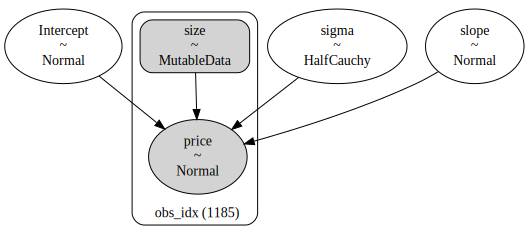

In [69]:
pm.model_to_graphviz(model)

In [70]:
likelihood

price

In [71]:
with model:
    idata = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, slope]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 30 seconds.


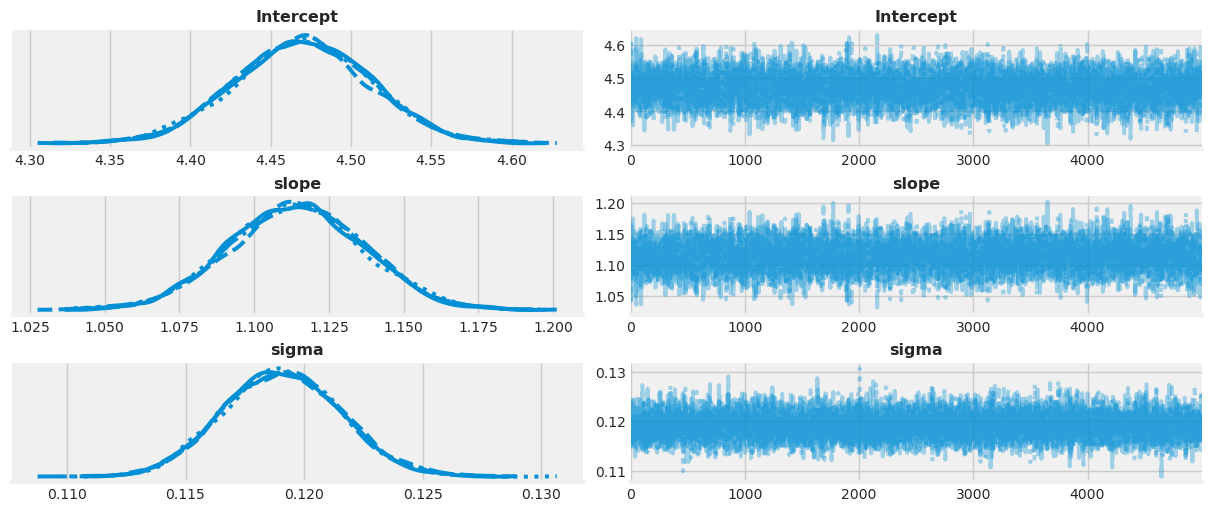

In [72]:
az.plot_trace(idata, figsize=FIGSIZE);

In [73]:
with model:
    pm.set_data({
        'size': np.log10(dv['size']),
    })
    # Generate posterior predictive samples
    ppd_dv = pm.sample_posterior_predictive(idata, predictions=True,)

Sampling: [price]


In [74]:
columns_order = ['size', 'latitude', 'longitude', 'rooms', 'buildYear',
              'price', 'pred_price', "residual"]

In [75]:
pred_price = (10**ppd_dv.predictions["price"]).mean(dim=["chain", "draw"]).data.round(0)
dv = dv.assign(pred_price=pred_price,
              residual = lambda d: d["price"] - d["pred_price"]).loc[:, columns_order]
dv

size   latitude  longitude  rooms  buildYear      price  pred_price  \
0    73.0  55.681720  12.583391      2       1690  5045000.0   3634755.0   
1    66.0  55.693832  12.534633      3       1911  3775000.0   3260109.0   
2    99.0  55.655476  12.505323      3       2020  4250000.0   5114222.0   
3    42.0  55.682552  12.562237      1       1969  2920000.0   1969089.0   
4    78.0  55.705750  12.493167      1       1959  2450000.0   3921801.0   
..    ...        ...        ...    ...        ...        ...         ...   
127  41.0  55.662650  12.606344      1       1940  2000000.0   1920948.0   
128  98.0  55.653294  12.565753      4       2019  6000000.0   5070108.0   
129  88.0  55.694294  12.534460      4       1913  3795000.0   4481524.0   
130  56.0  55.709373  12.564988      2       1934  2920000.0   2720119.0   
131  72.0  55.649258  12.611918      3       1968  3005000.0   3591372.0   

      residual  
0    1410245.0  
1     514891.0  
2    -864222.0  
3     950911.0  
4   -1471801.0  
..         ...  
127    79052.0  
128   929892.0  
129  -686524.0  
130   199881.0  
131  -586372.0  

[132 rows x 8 columns]

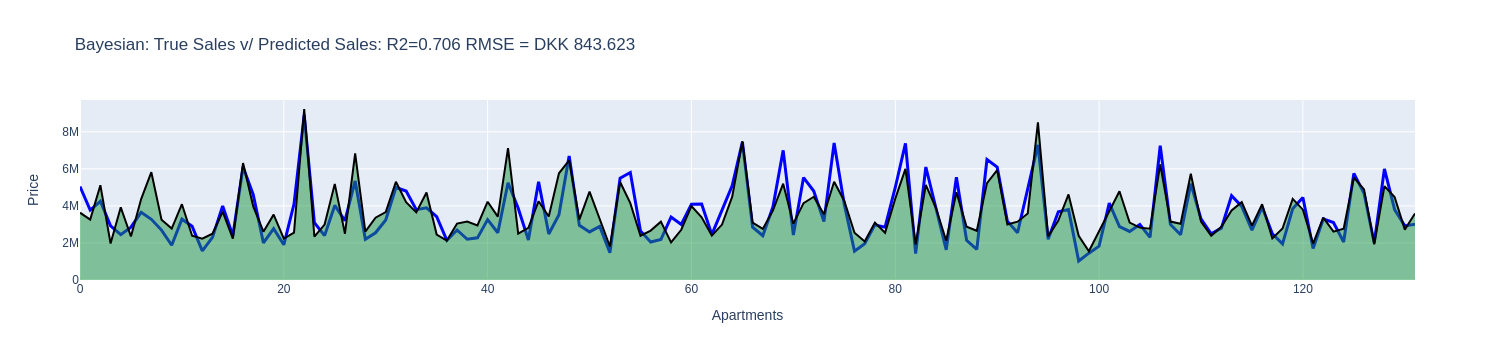

In [76]:
R2 = r2_score(dv["price"], dv["pred_price"]).round(3)
RMSE = f'{int(mean_squared_error(y_true=dv["price"], y_pred=dv["pred_price"], squared=False)):,}'.replace(
    ",", "."
)


(
    dv.plot(
        kind="line",
        y="price",
        title=f"Bayesian: True Sales v/ Predicted Sales: {R2=} RMSE = DKK {RMSE}",
    )
    .update_traces(line=dict(color="blue", width=3))
    .update_layout(
        hovermode="x unified",
        xaxis_title="Apartments",
        yaxis_title="Price",
    )
    .add_traces(
        dv.plot(kind="area", y="pred_price")
        .update_traces(
            line=dict(color="black", width=2,),
            fill="tonexty",
            fillcolor='rgba(26,150,65,0.5)',
        )
        .data
    )
)

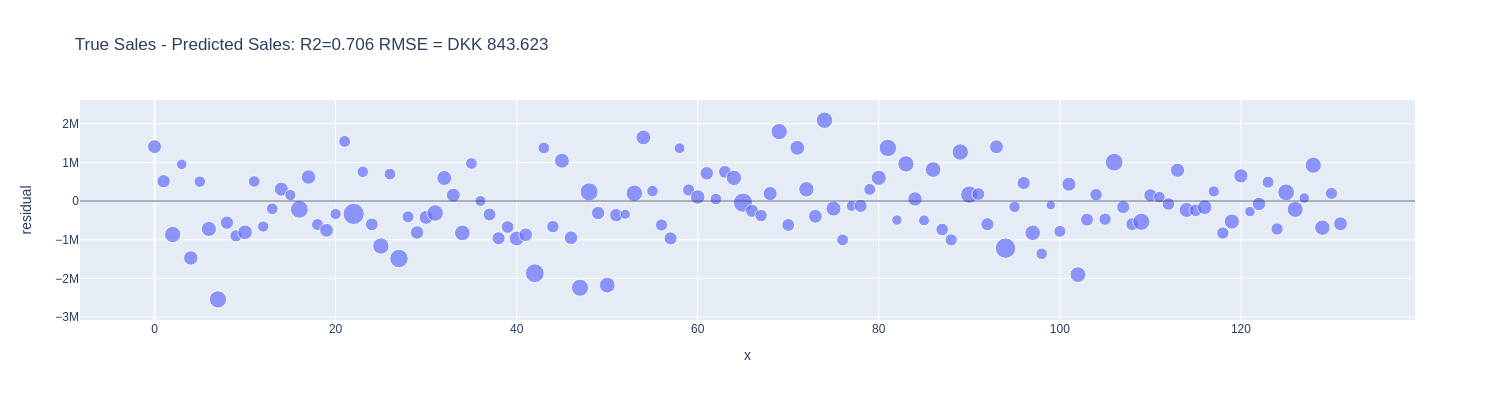

In [77]:

(
    dv.plot(
        kind="scatter",
        y="residual",
        x=p.index,
        size="size",
        size_max=15,
        title=f"True Sales - Predicted Sales: {R2=} RMSE = DKK {RMSE}",
        **fig_size,
    )
    .add_hline(
        y=0,
        opacity=0.4,
    )
    .update_traces(mode="markers")
    .update_layout(hovermode="y")
)

In [99]:
# price ~ size + rooms + 1   Treating rooms as not categorical ( X => price ~ size + C(rooms) + 1)

with pm.Model() as modelx: 
    # Define priors
    sigma = pm.HalfCauchy("sigma", beta=10)
    intercept = pm.HalfNormal("Intercept", sigma=20)
    
    Size = pm.Normal("Size", 0, sigma=20)
    Rooms = pm.Normal("Rooms", 0, sigma=10)

    # data
    size = pm.MutableData('size', np.log10(dt['size']), dims="obs_idx")
    rooms = pm.MutableData('rooms', dt['rooms'], dims="obs_idx")
    log_price = np.log10(dt['price'].values)
    # Define likelihood
    likelihood = pm.Normal("price", mu=intercept + Size * size + Rooms*rooms, sigma=sigma, observed=log_price, dims="obs_idx")

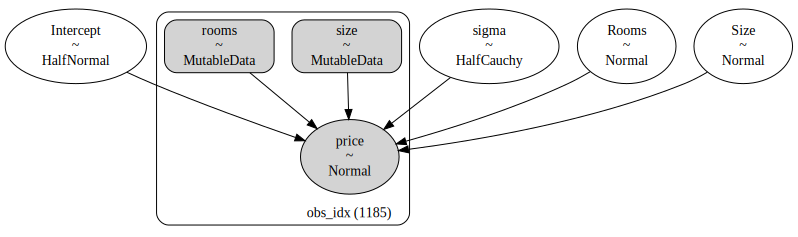

In [79]:
pm.model_to_graphviz(modelx)

In [80]:
likelihood

price

In [100]:
with modelx:
    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    idatax = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, Size, Rooms]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 62 seconds.


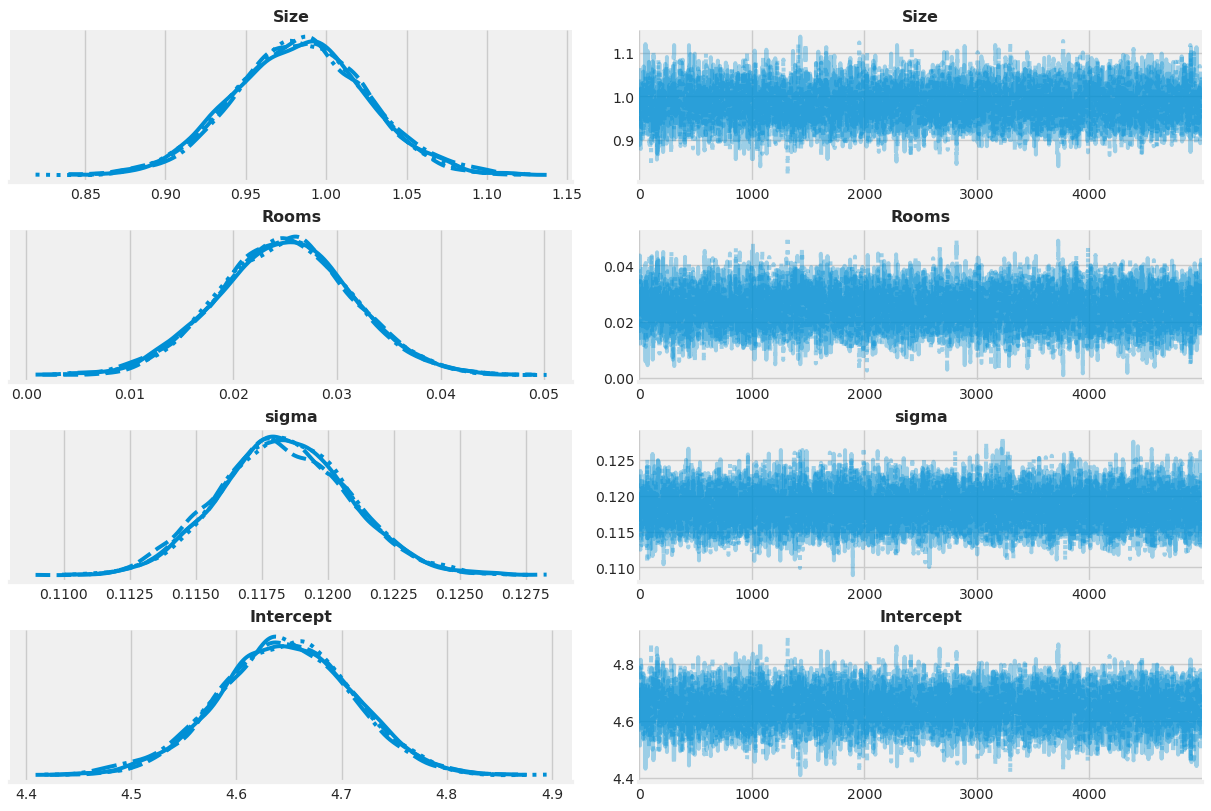

In [102]:
az.plot_trace(idatax);

In [109]:
with modelx:
    pm.set_data({
        'size': np.log10(dv['size']),
        'rooms': dv['rooms'],
    })
    # Generate posterior predictive samples
    ppd_dv = pm.sample_posterior_predictive(idatax, predictions=True, extend_inferencedata=True)

Sampling: [price]


In [104]:
pred_price = (10**ppd_dv.predictions["price"]).mean(dim=["chain", "draw"]).data.round(0)

dv = dv.assign(pred_price=pred_price,
              residual = lambda d: d["price"] - d["pred_price"]).loc[:, columns_order]
dv

size   latitude  longitude  rooms  buildYear      price  pred_price  \
0    73.0  55.681720  12.583391      2       1690  5045000.0   3504463.0   
1    66.0  55.693832  12.534633      3       1911  3775000.0   3359015.0   
2    99.0  55.655476  12.505323      3       2020  4250000.0   5027888.0   
3    42.0  55.682552  12.562237      1       1969  2920000.0   1927744.0   
4    78.0  55.705750  12.493167      1       1959  2450000.0   3542006.0   
..    ...        ...        ...    ...        ...        ...         ...   
127  41.0  55.662650  12.606344      1       1940  2000000.0   1878141.0   
128  98.0  55.653294  12.565753      4       2019  6000000.0   5262949.0   
129  88.0  55.694294  12.534460      4       1913  3795000.0   4716855.0   
130  56.0  55.709373  12.564988      2       1934  2920000.0   2703430.0   
131  72.0  55.649258  12.611918      3       1968  3005000.0   3670429.0   

      residual  
0    1540537.0  
1     415985.0  
2    -777888.0  
3     992256.0  
4   -1092006.0  
..         ...  
127   121859.0  
128   737051.0  
129  -921855.0  
130   216570.0  
131  -665429.0  

[132 rows x 8 columns]

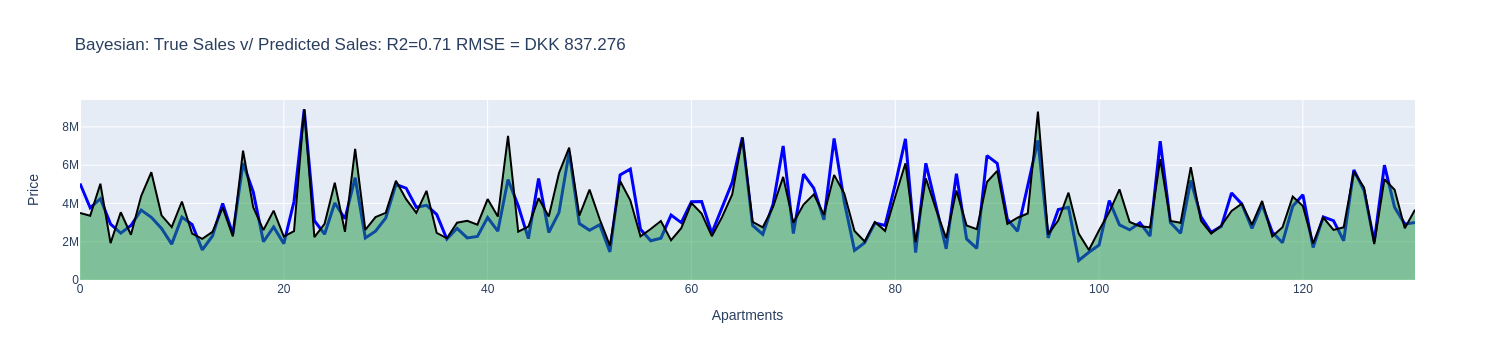

In [105]:
R2 = r2_score(dv["price"], dv["pred_price"]).round(3)
RMSE = f'{int(mean_squared_error(y_true=dv["price"], y_pred=dv["pred_price"], squared=False)):,}'.replace(
    ",", "."
)


(
    dv.plot(
        kind="line",
        y="price",
        title=f"Bayesian: True Sales v/ Predicted Sales: {R2=} RMSE = DKK {RMSE}",
    )
    .update_traces(line=dict(color="blue", width=3))
    .update_layout(
        hovermode="x unified",
        xaxis_title="Apartments",
        yaxis_title="Price",
    )
    .add_traces(
        dv.plot(kind="area", y="pred_price")
        .update_traces(
            line=dict(color="black", width=2,),
            fill="tonexty",
            fillcolor='rgba(26,150,65,0.5)',
        )
        .data
    )
)

In [86]:
rooms, rooms_idx = np.unique(dt["rooms"], return_inverse=True)
log_price = np.log10(dt['price'])

In [87]:
coords = {"Rooms": rooms}
with pm.Model(coords=coords) as modely:

    log_price_ = pm.MutableData("log_price", log_price)
    rooms_idx_ = pm.MutableData("rooms_idx", rooms_idx)
    size = pm.MutableData("size", np.log10(dt["size"]),)
     # Define priors
    
    
    β0 = pm.Normal("β0", 0, sigma=20, dims="Rooms")
    β1 = pm.Normal("β1", 0, sigma=20, dims="Rooms")

    # sigma = pm.HalfNormal("σ", sigma=5)
    sigma = pm.HalfCauchy("σ", beta=10)


    mu = β0[rooms_idx_] + β1[rooms_idx_] * size
    
     # Define likelihood
    likelihood = pm.Normal("price", mu=mu, sigma=sigma, observed=log_price_, shape=mu.shape)

In [88]:
likelihood

price

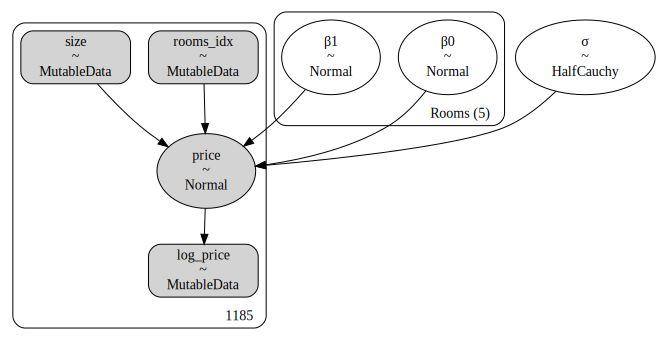

In [89]:
pm.model_to_graphviz(modely)

In [90]:
with modely:
    # Inference!
    # draw 5000 posterior samples using NUTS sampling
    idatay = pm.sample(5000)

    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β0, β1, σ]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 191 seconds.


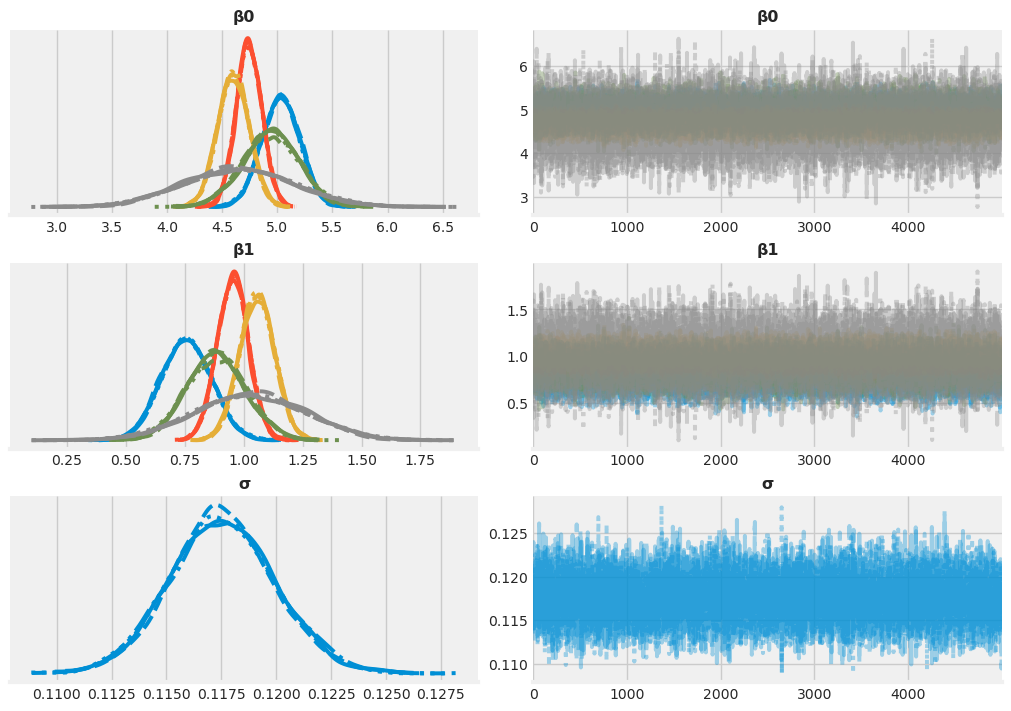

In [91]:
az.plot_trace(idatay, figsize=(10, 7));

In [92]:
# Map the species in the test data to the original index values from the train dataset
name_to_idx_map = {name: index for index, name in pd.Series(rooms).to_dict().items()}
rooms_idx_dv = dv["rooms"].map(name_to_idx_map).to_numpy()

In [94]:
with modely:
    pm.set_data(
        {
            "size": np.log10(dv["size"]),
            "rooms_idx": rooms_idx_dv,
        }
    )

In [95]:
with modely:
    # Generate posterior predictive samples
    ppd_dv = pm.sample_posterior_predictive(idatay, predictions=True)

Sampling: [price]


In [96]:
pred_price = (10**ppd_dv.predictions["price"]).mean(dim=["chain", "draw"]).data.round(0)

dv = dv.assign(pred_price=pred_price,
              residual = lambda d: d["price"] - d["pred_price"]).loc[:, columns_order]
dv

size   latitude  longitude  rooms  buildYear      price  pred_price  \
0    73.0  55.681720  12.583391      2       1690  5045000.0   3427571.0   
1    66.0  55.693832  12.534633      3       1911  3775000.0   3465485.0   
2    99.0  55.655476  12.505323      3       2020  4250000.0   5315483.0   
3    42.0  55.682552  12.562237      1       1969  2920000.0   1890300.0   
4    78.0  55.705750  12.493167      1       1959  2450000.0   3029505.0   
..    ...        ...        ...    ...        ...        ...         ...   
127  41.0  55.662650  12.606344      1       1940  2000000.0   1859774.0   
128  98.0  55.653294  12.565753      4       2019  6000000.0   5173146.0   
129  88.0  55.694294  12.534460      4       1913  3795000.0   4715652.0   
130  56.0  55.709373  12.564988      2       1934  2920000.0   2675129.0   
131  72.0  55.649258  12.611918      3       1968  3005000.0   3794080.0   

      residual  
0    1617429.0  
1     309515.0  
2   -1065483.0  
3    1029700.0  
4    -579505.0  
..         ...  
127   140226.0  
128   826854.0  
129  -920652.0  
130   244871.0  
131  -789080.0  

[132 rows x 8 columns]

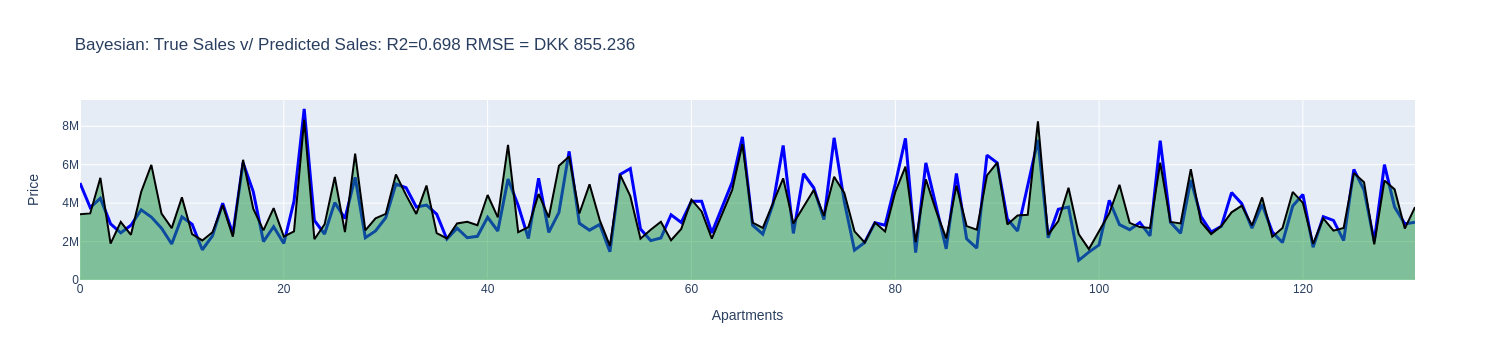

In [97]:
R2 = r2_score(dv["price"], dv["pred_price"]).round(3)
RMSE = f'{int(mean_squared_error(y_true=dv["price"], y_pred=dv["pred_price"], squared=False)):,}'.replace(
    ",", "."
)


(
    dv.plot(
        kind="line",
        y="price",
        title=f"Bayesian: True Sales v/ Predicted Sales: {R2=} RMSE = DKK {RMSE}",
    )
    .update_traces(line=dict(color="blue", width=3))
    .update_layout(
        hovermode="x unified",
        xaxis_title="Apartments",
        yaxis_title="Price",
    )
    .add_traces(
        dv.plot(kind="area", y="pred_price")
        .update_traces(
            line=dict(color="black", width=2,),
            fill="tonexty",
            fillcolor='rgba(26,150,65,0.5)',
        )
        .data
    )
)

# From Predictions to Business Insights
Making decisions base on modeling

/home/prayson/Code/hadithi/dev.io/.pixi/env/lib/python3.11/site-packages/arviz/plots/plot_utils.py:271: UserWarning:

rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (132) in plot_posterior, generating only 40 plots



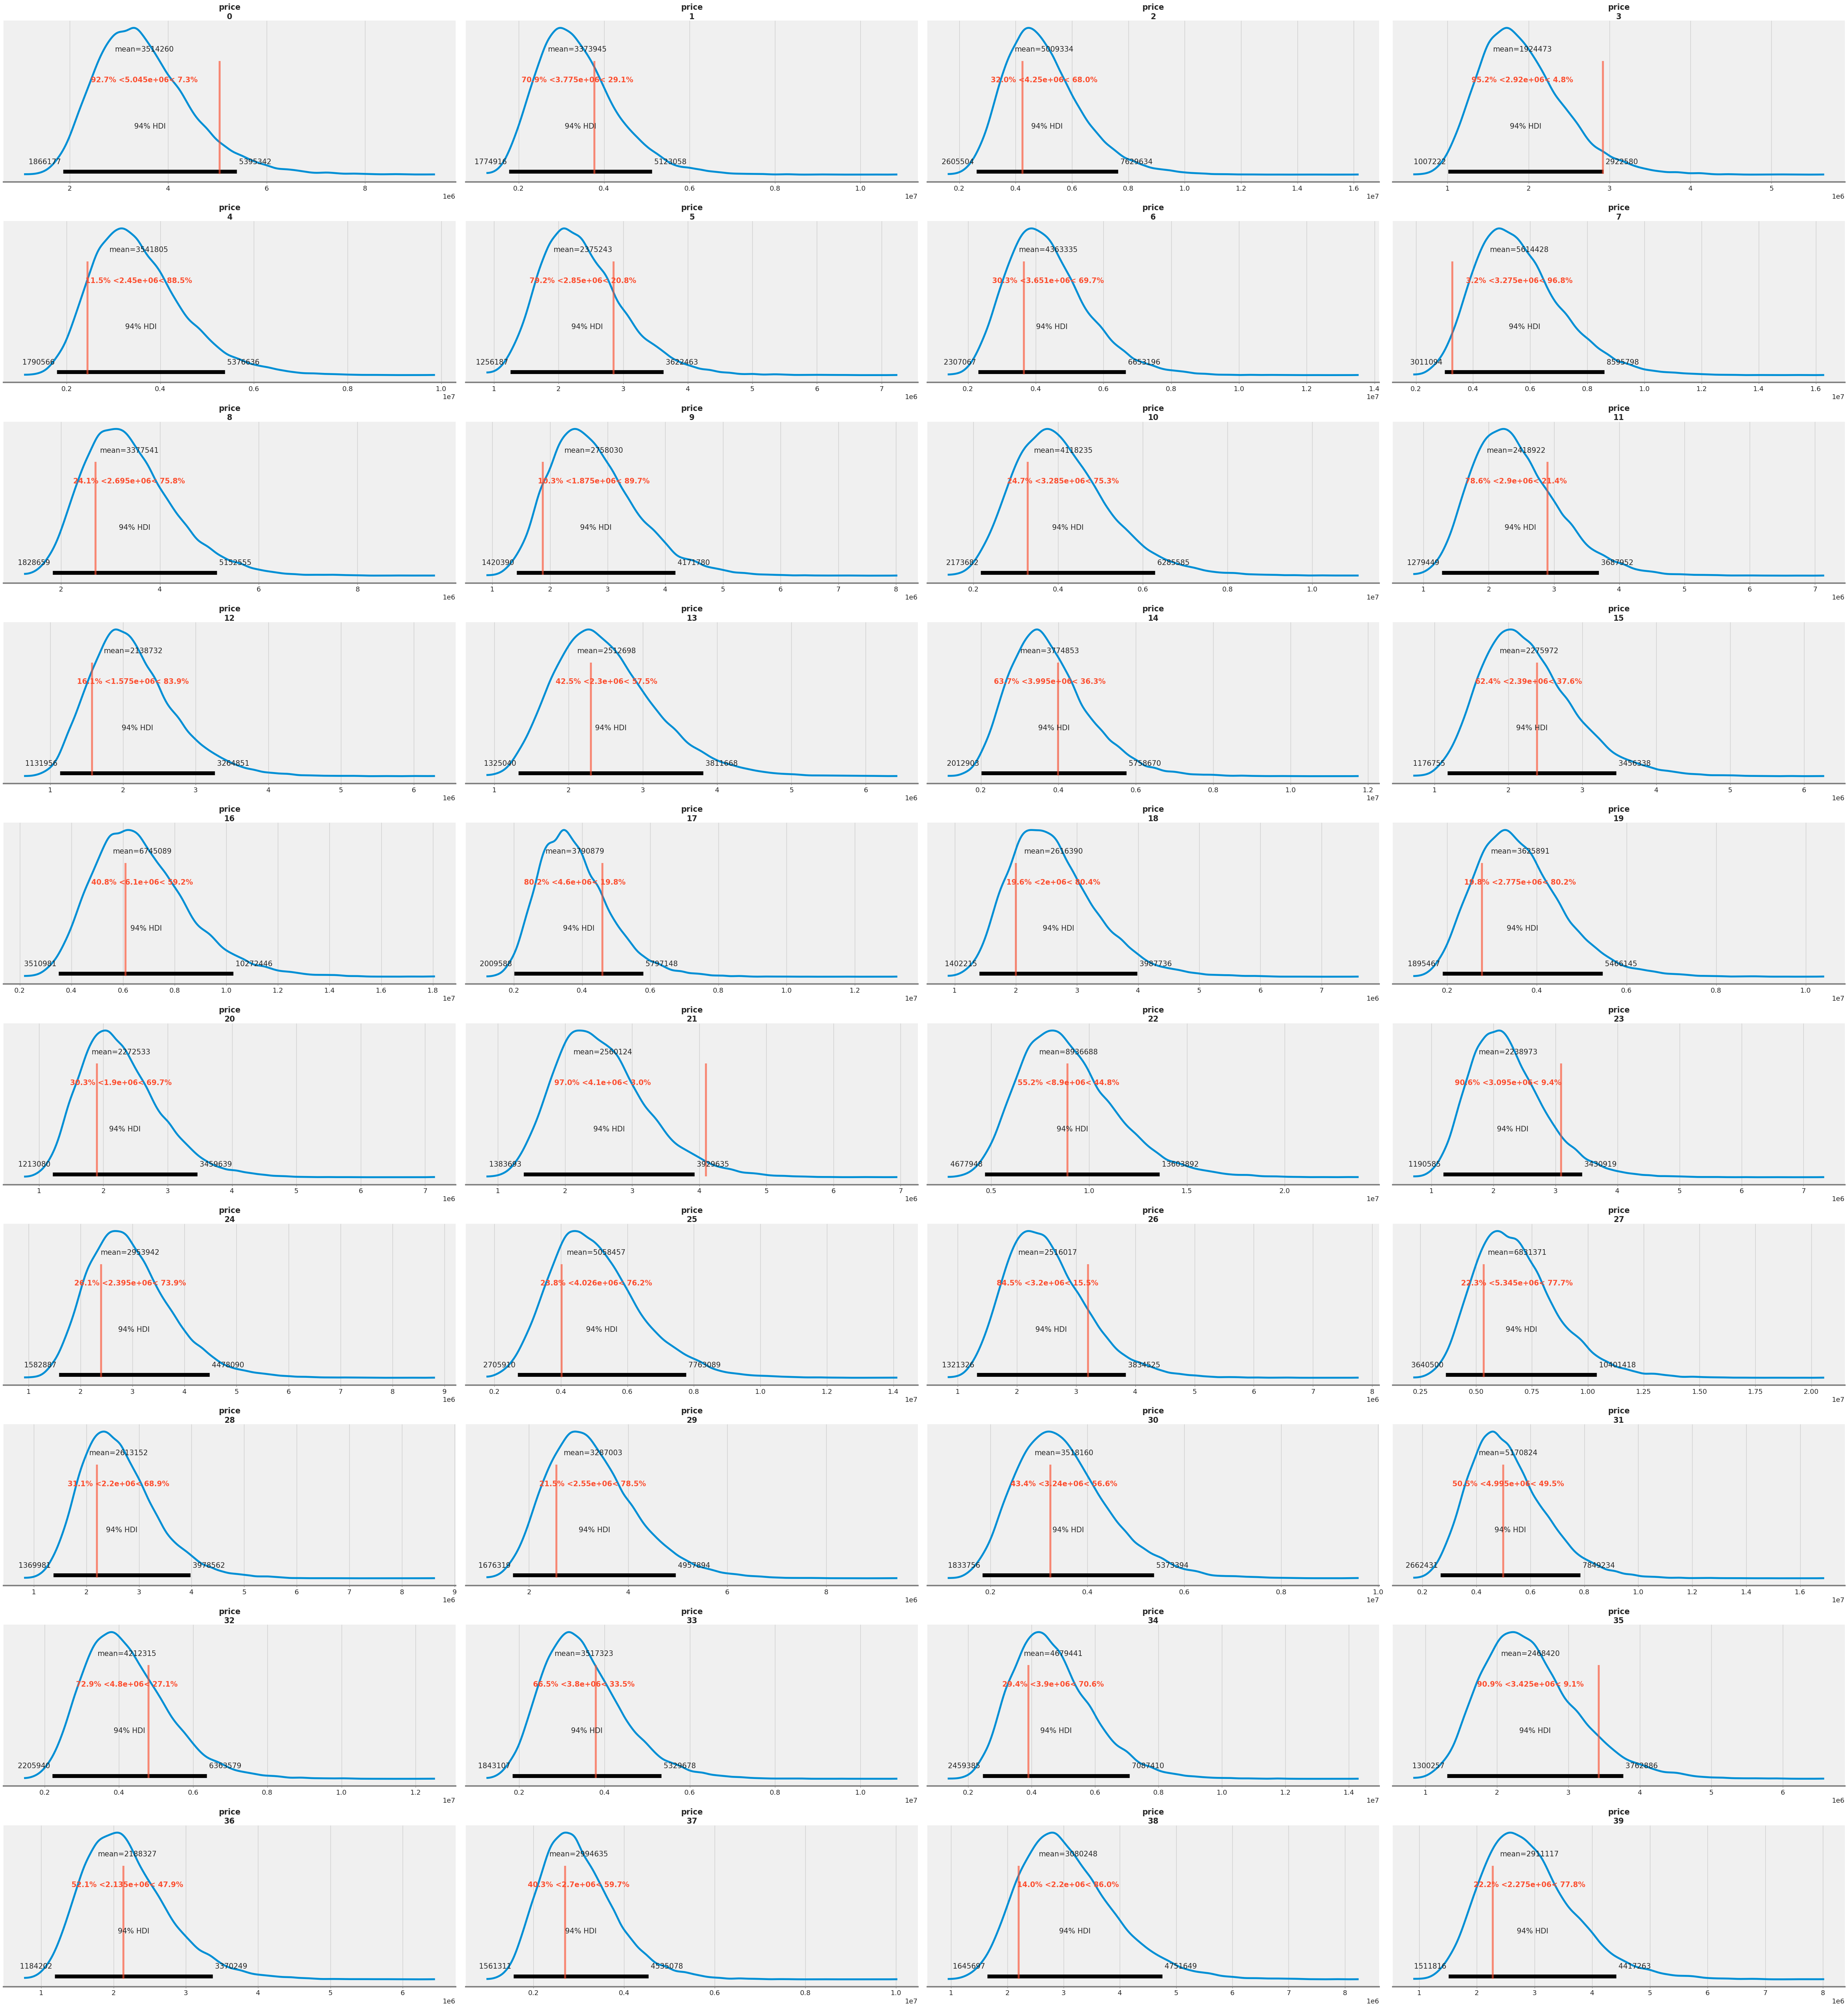

In [168]:
az.plot_posterior(
    10**idatax.predictions,
    ref_val=dv["price"].tolist(),
    transform=None,
);

In [189]:
M = 1e6
obs_idx = 13
threshold = 2.5 * M
actual_price = dv["price"].astype(int).iloc[obs_idx]
#(predictions >= threshold).mean(dim=("chain", "draw")).round(2)

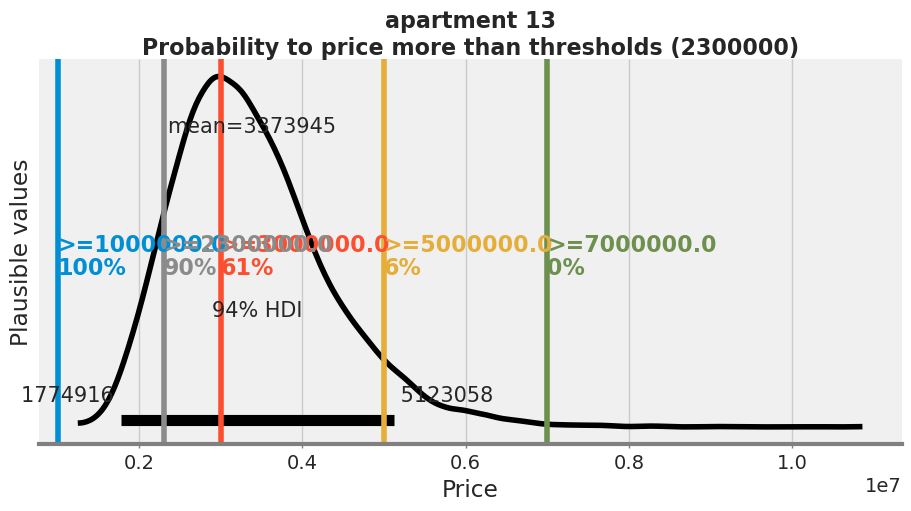

In [190]:
price_zero_predictions = predictions["price"].sel(obs_idx=obs_indx)
_, ax = plt.subplots(figsize=(9, 5))
ax = az.plot_posterior(price_zero_predictions, color="k", ax=ax)

for k, threshold in enumerate(np.array([1, 3, 5, 7, actual_price/M])*M):
    probs_above_threshold = (price_zero_predictions >= threshold).mean(dim=("chain", "draw"))

    ax.axvline(threshold, color=f"C{k}")
    _, pdf = az.kde(price_zero_predictions.stack(sample=("chain", "draw")).data)
    ax.text(
        x=threshold - 35,
        y=pdf.max() / 2,
        s=f">={threshold:}",
        color=f"C{k}",
        fontsize="16",
        fontweight="bold",
    )
    ax.text(
        x=threshold - 20,
        y=pdf.max() / 2.3,
        s=f"{probs_above_threshold.data:.0%}",
        color=f"C{k}",
        fontsize="16",
        fontweight="bold",
    )
    ax.set_title(f"apartment {obs_idx}\nProbability to price more than thresholds ({actual_price})", fontsize=16)
    ax.set(xlabel="Price", ylabel="Plausible values")

/home/prayson/Code/hadithi/dev.io/.pixi/env/lib/python3.11/site-packages/arviz/plots/plot_utils.py:271: UserWarning:

rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (132) in plot_posterior, generating only 40 plots



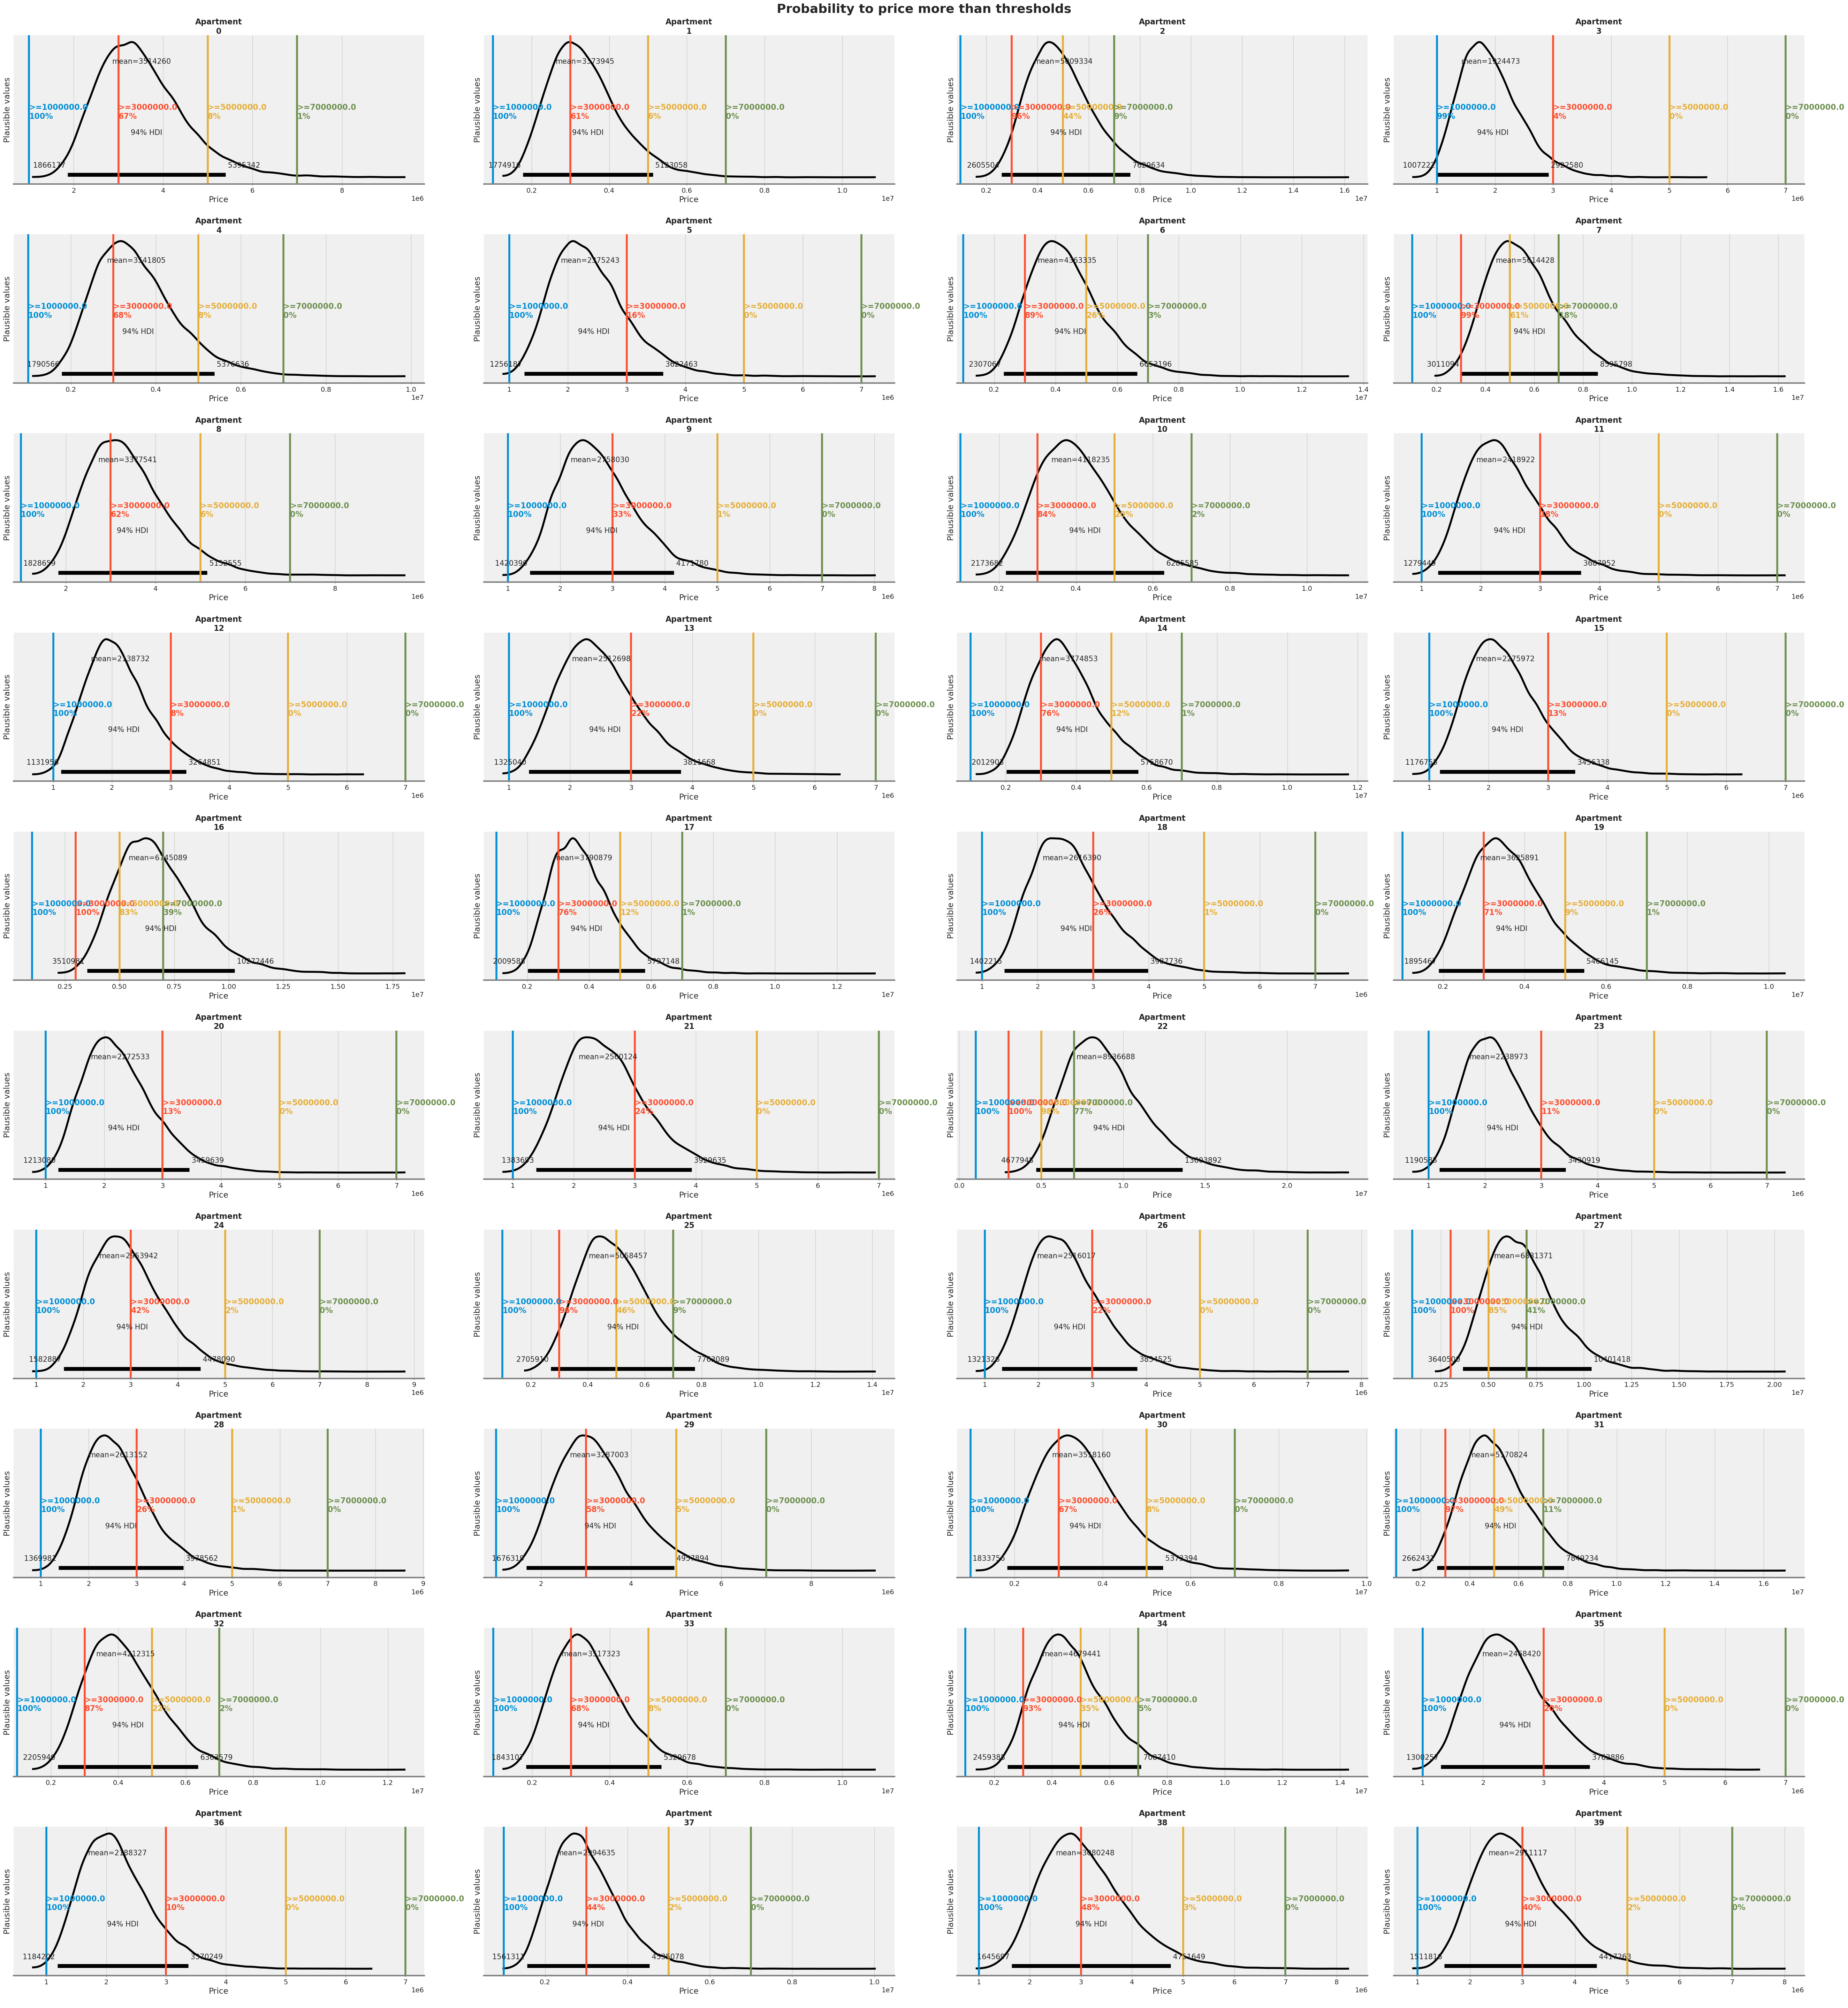

In [191]:
axes = az.plot_posterior(predictions, color="k")

for k, threshold in enumerate(np.array([1, 3, 5, 7])*M):
    probs_above_threshold = (predictions >= threshold).mean(dim=("chain", "draw"))
    
    for i, ax in enumerate(axes.ravel()):
        ax.axvline(threshold, color=f"C{k}")
        _, pdf = az.kde(predictions["price"].sel(obs_idx=i).stack(sample=("chain", "draw")).data)
        ax.text(
            x=threshold - 35,
            y=pdf.max() / 2,
            s=f">={threshold}",
            color=f"C{k}",
            fontsize="16",
            fontweight="bold",
        )
        ax.text(
            x=threshold - 20,
            y=pdf.max() / 2.3,
            s=f"{probs_above_threshold.sel(obs_idx=i)['price'].data :.0%}",
            color=f"C{k}",
            fontsize="16",
            fontweight="bold",
        )
        ax.set_title(f"Apartment\n{i}", fontsize=16)
        ax.set(xlabel="Price\n", ylabel="Plausible values")
plt.suptitle("Probability to price more than thresholds", fontsize=26, fontweight="bold");

# All features

In [ ]:
dv["price"].head()

In [ ]:
# price ~ size + rooms + latitude + logitude + 1    

with pm.Model() as model: 
    # Define priors
    sigma = pm.HalfCauchy("sigma", beta=10)
    intercept = pm.HalfNormal("Intercept", sigma=20)
    
    Size = pm.Normal("Size", 0, sigma=20)
    Rooms = pm.Normal("Rooms", 0, sigma=20)

    Latitude = pm.Normal("Latitude", 0, sigma=20)
    Longitude = pm.Normal("Longitude", 0, sigma=20)

    # data
    size = pm.MutableData('size', np.log10(dt['size']), dims="obs_idx")
    rooms = pm.MutableData('rooms', dt['rooms'], dims="obs_idx")
    latitude = pm.MutableData('latitude', np.log10(dt['latitude']), dims="obs_idx")
    longitude = pm.MutableData('longitude', np.log10(dt['longitude']), dims="obs_idx")

    
    log_price = np.log10(dt['price'].values)
    # Define likelihood
    likelihood = pm.Normal("price", mu=intercept + Size * size + Rooms*rooms + Latitude*latitude + Longitude*longitude, sigma=sigma, observed=log_price, dims="obs_idx")

    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    idata = pm.sample(5000)

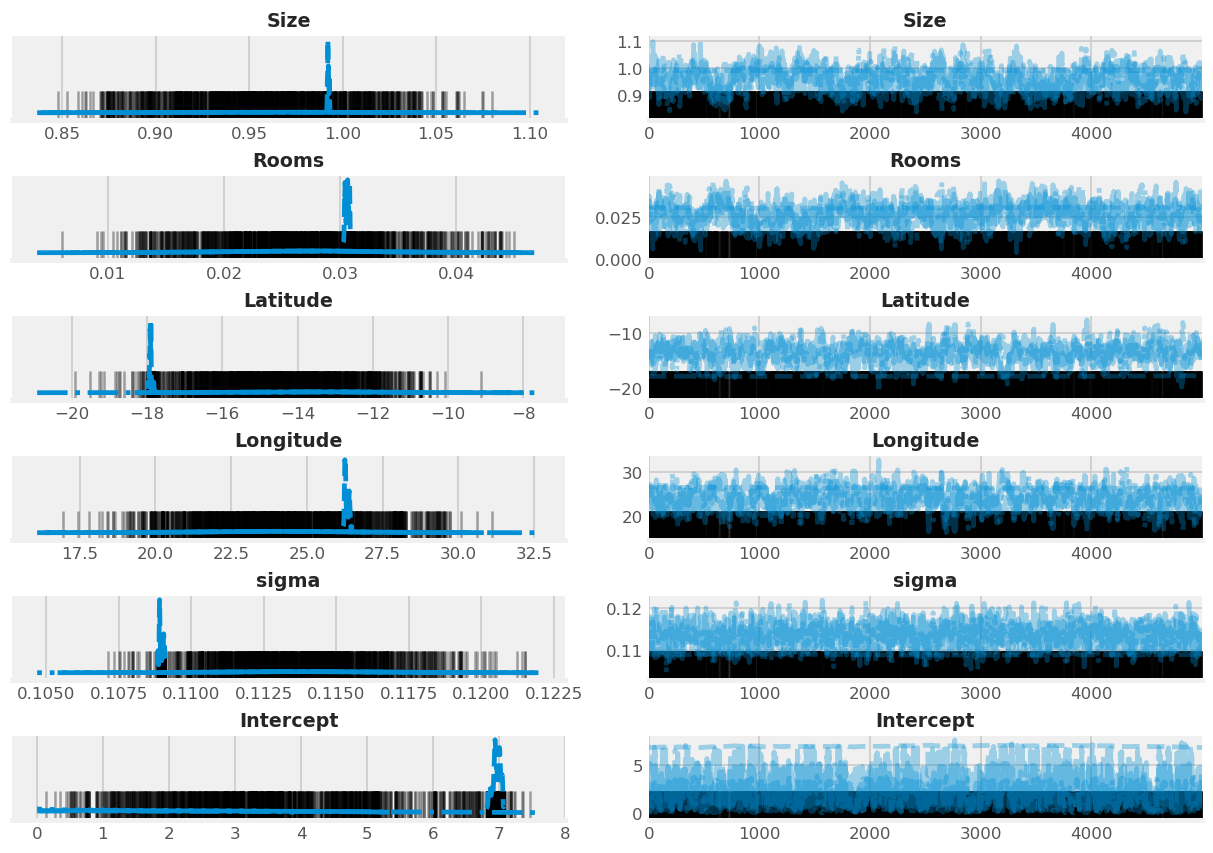

In [200]:
az.plot_trace(idata, figsize=(10, 7));

In [189]:
with model:
    pm.set_data({
        'size': np.log10(dv['size']),
        'rooms': dv['rooms'],
        'latitude': np.log10(dv['latitude']),
        'longitude': np.log10(dv['longitude']),
    })
    # Generate posterior predictive samples
    ppd_dv = pm.sample_posterior_predictive(idata, predictions=True)

Sampling: [price]


In [190]:
pred_price = (10**ppd_dv.predictions["price"]).mean(dim=["chain", "draw"]).data.round(0)

dv = dv.assign(pred_price=pred_price,
              residual = lambda d: d["price"] - d["pred_price"]).loc[:, columns_order]
dv

size   latitude  longitude  rooms  buildYear      price  pred_price  \
0    73.0  55.681720  12.583391      2       1690  5045000.0   3683902.0   
1    66.0  55.693832  12.534633      3       1911  3775000.0   3232650.0   
2    99.0  55.655476  12.505323      3       2020  4250000.0   4550587.0   
3    42.0  55.682552  12.562237      1       1969  2920000.0   1939578.0   
4    78.0  55.705750  12.493167      1       1959  2450000.0   3077329.0   
..    ...        ...        ...    ...        ...        ...         ...   
127  41.0  55.662650  12.606344      1       1940  2000000.0   2081440.0   
128  98.0  55.653294  12.565753      4       2019  6000000.0   5415067.0   
129  88.0  55.694294  12.534460      4       1913  3795000.0   4536137.0   
130  56.0  55.709373  12.564988      2       1934  2920000.0   2733299.0   
131  72.0  55.649258  12.611918      3       1968  3005000.0   4128649.0   

      residual  
0    1361098.0  
1     542350.0  
2    -300587.0  
3     980422.0  
4    -627329.0  
..         ...  
127   -81440.0  
128   584933.0  
129  -741137.0  
130   186701.0  
131 -1123649.0  

[132 rows x 8 columns]

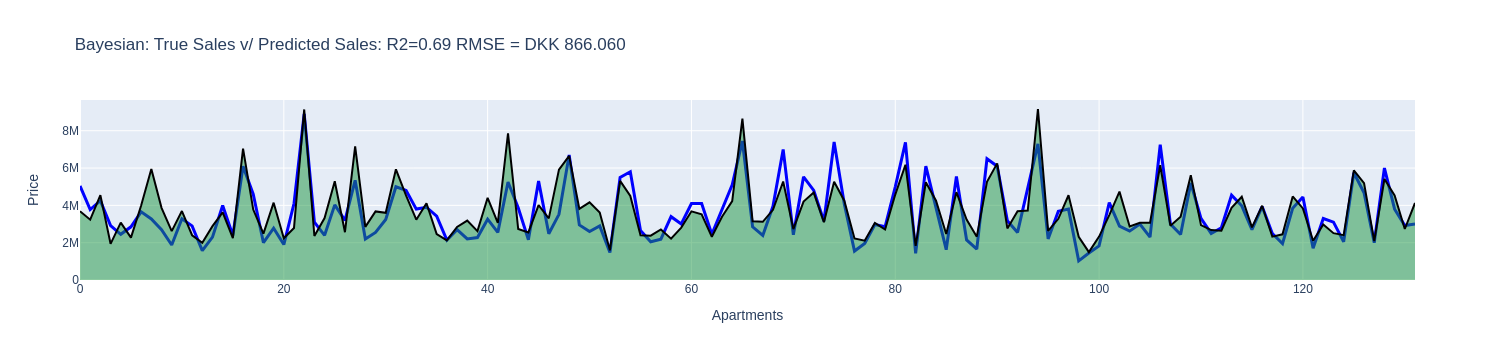

In [191]:
R2 = r2_score(dv["price"], dv["pred_price"]).round(3)
RMSE = f'{int(mean_squared_error(y_true=dv["price"], y_pred=dv["pred_price"], squared=False)):,}'.replace(
    ",", "."
)


(
    dv.plot(
        kind="line",
        y="price",
        title=f"Bayesian: True Sales v/ Predicted Sales: {R2=} RMSE = DKK {RMSE}",
    )
    .update_traces(line=dict(color="blue", width=3))
    .update_layout(
        hovermode="x unified",
        xaxis_title="Apartments",
        yaxis_title="Price",
    )
    .add_traces(
        dv.plot(kind="area", y="pred_price")
        .update_traces(
            line=dict(color="black", width=2,),
            fill="tonexty",
            fillcolor='rgba(26,150,65,0.5)',
        )
        .data
    )
)

In [196]:
#fig = _
#fig.write_html("assets/example.html", full_html=True, include_plotlyjs='cdn')

# all features end